In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.style.use('default')


In [3]:
df = pd.read_csv("../data/survey/results.csv")
df.head()

,participant_email,puzzle_id,max_moves,player_moves,time_taken_seconds
0,*,dataset-1,2,3,7
1,*,dataset-14,3,3,6
2,*,dataset-1,2,2,7
3,*,dataset-14,3,3,8
4,*,dataset-52,4,4,4


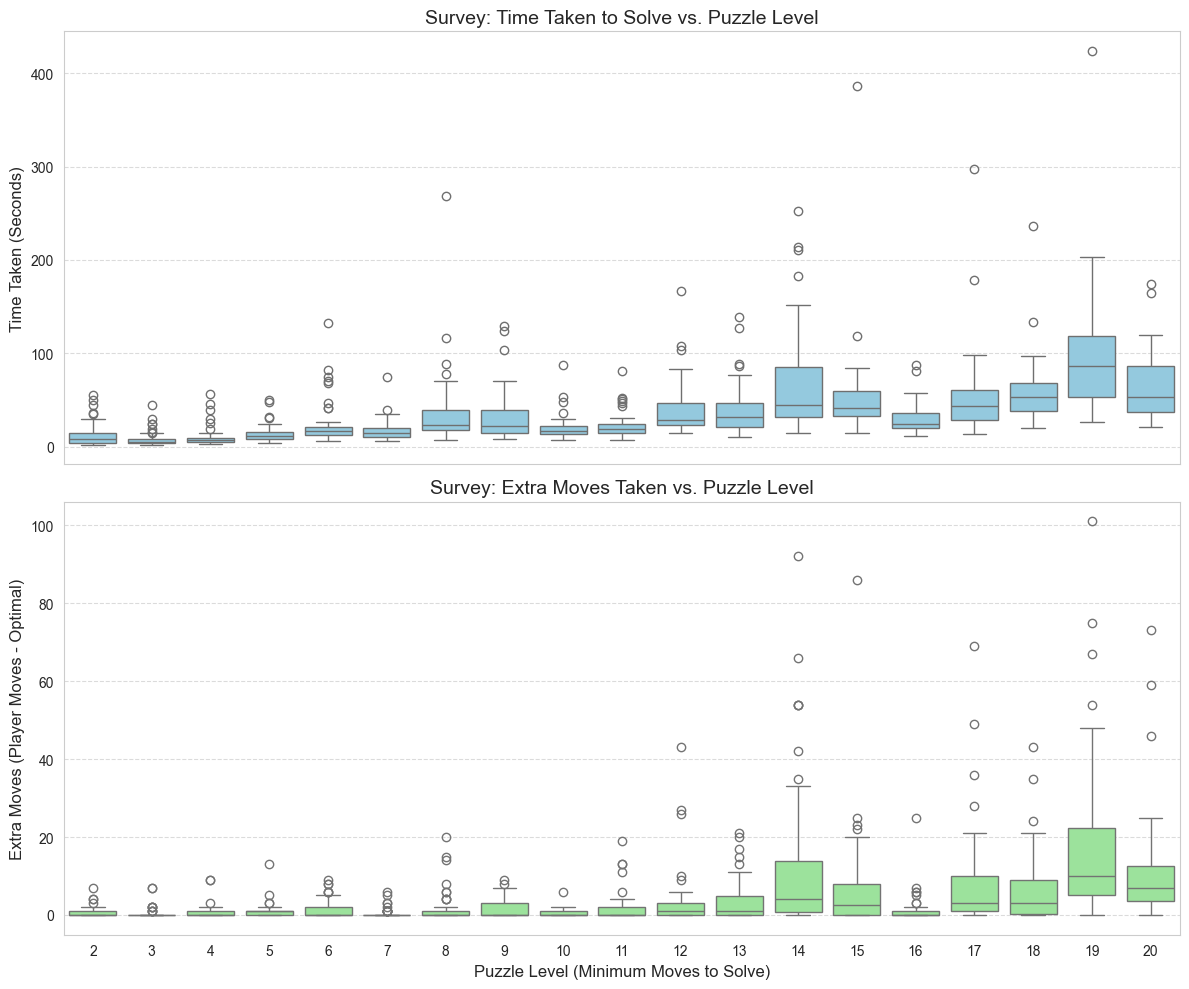

In [24]:
# Calculate 'excess_moves' to measure efficiency
# Excess Moves = Actual Moves Taken - Optimal Minimum Moves
df['excess_moves'] = df['player_moves'] - df['max_moves']

# Create a figure with two subplots to show different aspects of difficulty
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Time Difficulty
# Boxplot shows the median and spread of time taken for each level
sns.boxplot(x='max_moves', y='time_taken_seconds', data=df, ax=ax1, color='skyblue')
ax1.set_title('Survey: Time Taken to Solve vs. Puzzle Level', fontsize=14)
ax1.set_ylabel('Time Taken (Seconds)', fontsize=12)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Plot 2: Cognitive Difficulty (Efficiency)
# Boxplot shows how many "extra" moves players needed
sns.boxplot(x='max_moves', y='excess_moves', data=df, ax=ax2, color='lightgreen')
ax2.set_title('Survey: Extra Moves Taken vs. Puzzle Level', fontsize=14)
ax2.set_xlabel('Puzzle Level (Minimum Moves to Solve)', fontsize=12)
ax2.set_ylabel('Extra Moves (Player Moves - Optimal)', fontsize=12)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('difficulty_analysis.png')
plt.show()

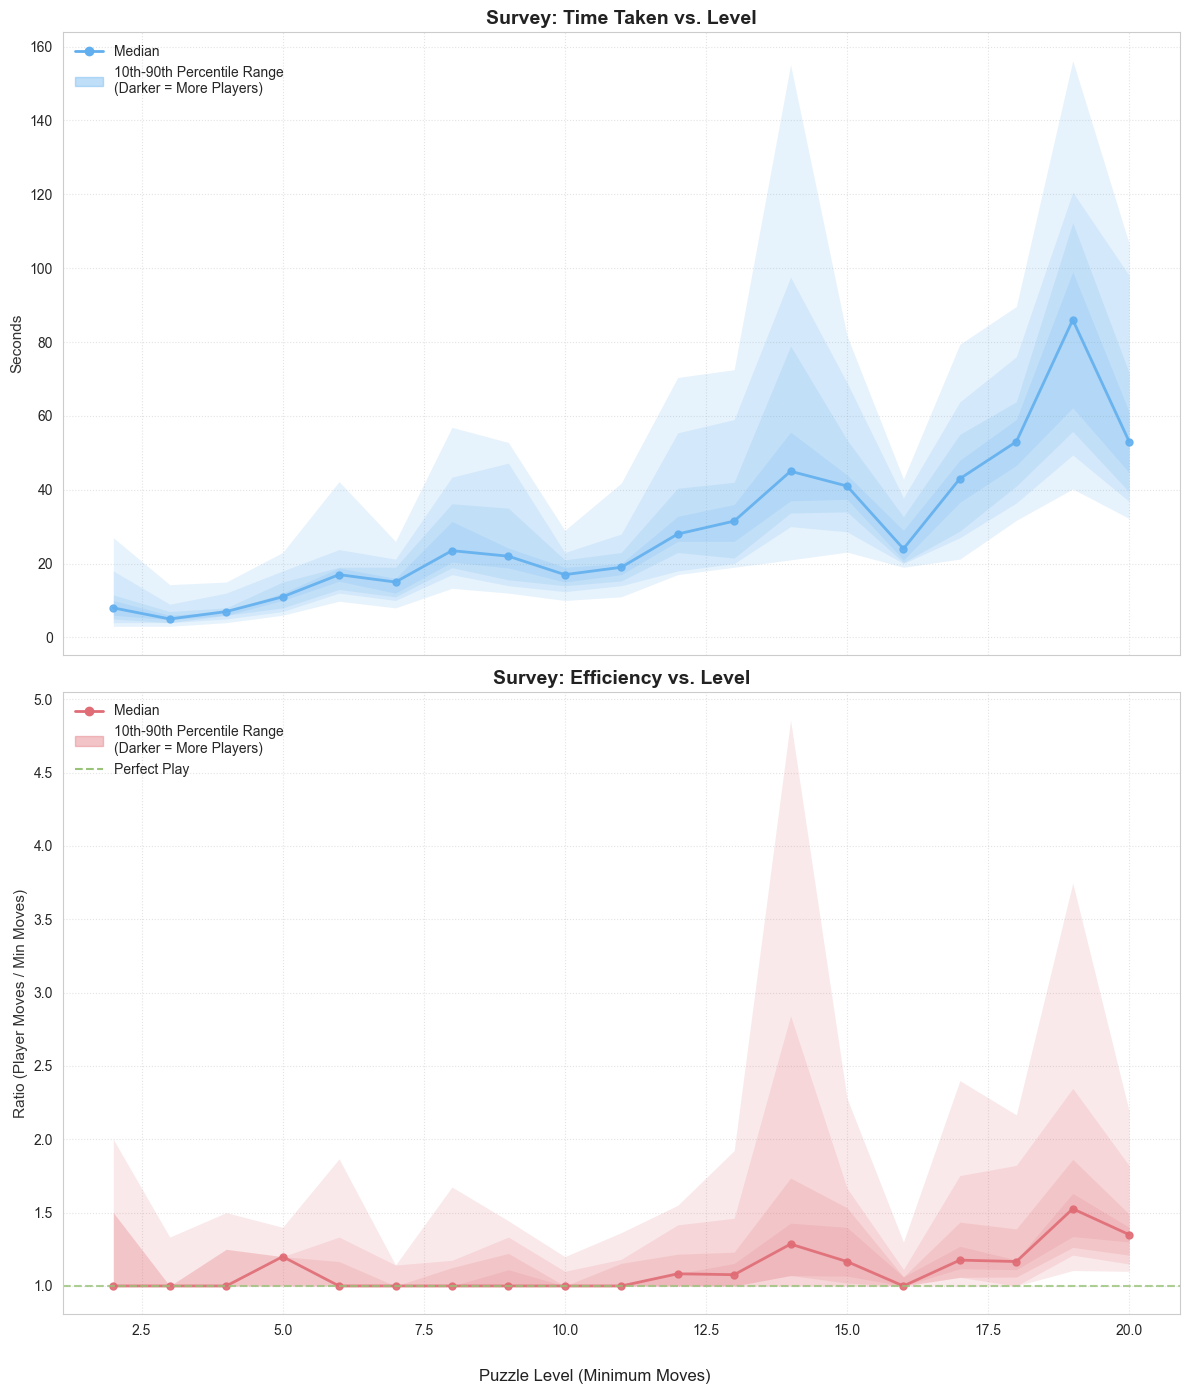

In [23]:
# Calculate efficiency metric
# Optimality Ratio: 1.0 means perfect play. >1.0 means extra moves were used.
df['optimality_ratio'] = df['player_moves'] / df['max_moves']

# 2. Define the Fan Chart Plotting Function
def plot_fan_chart(ax, x_col, y_col, data, base_color, title, ylabel, show_ref_line=False):
    """
    Plots a 'Fan Chart' showing data density using layered percentile bands.
    """
    # Group by level (x_col)
    grouped = data.groupby(x_col)[y_col]

    # Calculate the Median (The spine of the plot)
    medians = grouped.median()
    x_vals = medians.index

    # Define percentile steps for the gradient (from wide/light to narrow/dark)
    # We will step from the 10th-90th range in towards the center.
    # Pairs: (10, 90), (20, 80), (30, 70), (40, 60)
    steps = [10, 20, 30, 40]

    # Plot the bands from widest (lightest) to narrowest (darkest)
    # Alpha is low so they stack to create depth
    alpha_step = 0.15

    for step in steps:
        lower_p = step
        upper_p = 100 - step

        # Calculate percentiles for this band
        lower_band = grouped.quantile(lower_p / 100)
        upper_band = grouped.quantile(upper_p / 100)

        # Fill the area
        ax.fill_between(x_vals, lower_band, upper_band,
                        color=base_color, alpha=alpha_step, lw=0)

    # Plot the Median line on top (Solid and clear)
    ax.plot(x_vals, medians, color=base_color, linewidth=2, marker='o',
            markersize=5, alpha=0.9, label='Median')

    # Styling
    ax.set_title(title, fontsize=14, fontweight='bold', color='#222222')
    ax.set_ylabel(ylabel, fontsize=11, color='#333333')
    ax.set_facecolor('white')
    ax.grid(True, linestyle=':', alpha=0.4, color='#bbbbbb')

    # Optional reference line for "Perfect Play"
    if show_ref_line:
        ax.axhline(y=1.0, color='#98c379', linestyle='--', linewidth=1.5, alpha=0.8, label='Perfect Efficiency (1.0)')

# 3. Create the Figure
fig, axes = plt.subplots(2, 1, figsize=(12, 14), sharex=True)
ax1, ax2 = axes

# --- Plot 1: Time Taken (Blue Depth) ---
plot_fan_chart(
    ax=ax1,
    x_col='max_moves',
    y_col='time_taken_seconds',
    data=df,
    base_color='#61afef',  # Bright Blue
    title='Survey: Time Taken vs. Level',
    ylabel='Seconds'
)

# --- Plot 2: Efficiency (Red/Orange Depth) ---
plot_fan_chart(
    ax=ax2,
    x_col='max_moves',
    y_col='optimality_ratio',
    data=df,
    base_color='#e06c75',  # Soft Red
    title='Survey: Efficiency vs. Level',
    ylabel='Ratio (Player Moves / Min Moves)',
    show_ref_line=True
)

# 4. Add Custom Legends
def create_gradient_legend(color, ax):
    # Create proxy artists for the legend
    median_line = plt.Line2D([0], [0], color=color, marker='o', lw=2, label='Median')

    # Create a patch to represent the gradient range
    range_patch = mpatches.Patch(color=color, alpha=0.4, label='10th-90th Percentile Range\n(Darker = More Players)')

    handles = [median_line, range_patch]

    # Add the green line for the second plot if needed
    if ax == ax2:
        ref_line = plt.Line2D([0], [0], color='#98c379', linestyle='--', lw=1.5, label='Perfect Play')
        handles.append(ref_line)

    ax.legend(handles=handles, loc='upper left', frameon=False, fontsize=10)

create_gradient_legend('#61afef', ax1)
create_gradient_legend('#e06c75', ax2)

# Global X Label
fig.text(0.5, 0.01, 'Puzzle Level (Minimum Moves)', ha='center', fontsize=12, color='#222222')

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('depth_analysis.png', dpi=300, facecolor='white')
plt.show()
